# GAN 

- 생성자와 판별자가 서로 경쟁(Adversarial)하며 데이터를 생성(Generative)하는 모델(Network)

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

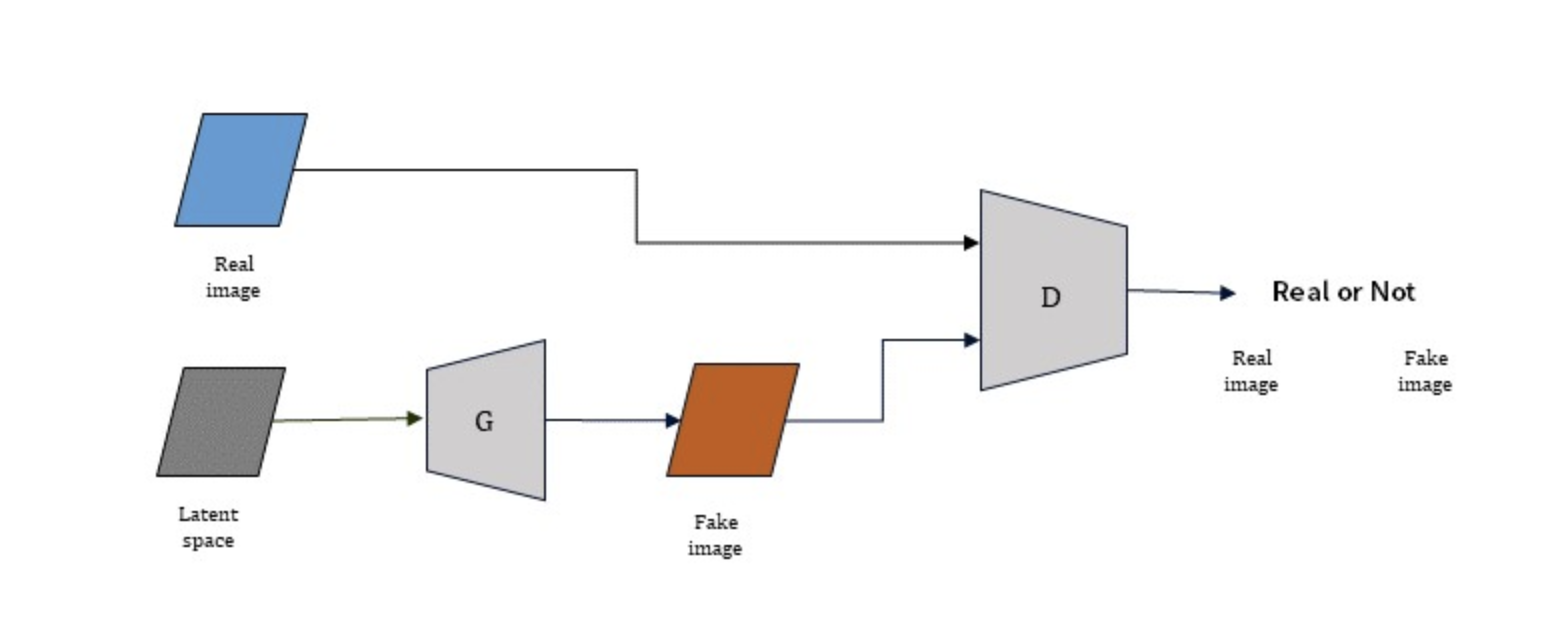

In [2]:
Image("./gan.png")

* Discriminator: 진짜 데이터는 진짜로, 가짜 데이터는 가짜로 구별하도록 학습하는것 
* Generator: Discriminator를 속이기 위한 진짜 데이터 같은 가짜 데이터 생성

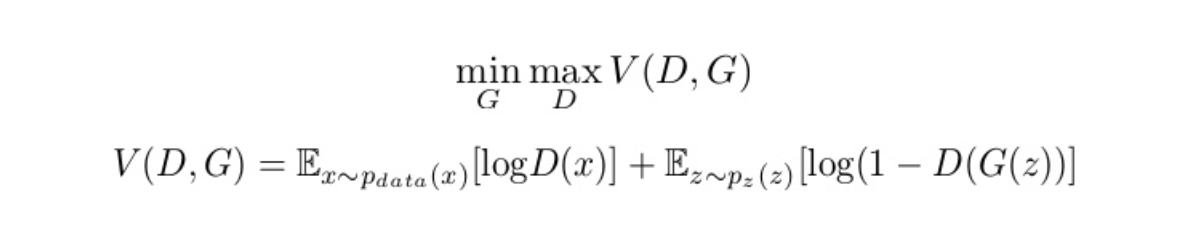

In [3]:
Image("./gan_loss.png")

* Discriminator: V(D,G)가 최대
        - 가짜 데이터는 0을 출력, 진짜 데이터는 1을 출력
        - x: 진짜 데이터, G(z): 가짜 데이터
        - D는 D(x)=1, D(G(z))=0이 되도록 해야함
* Generator: V(D,G)가 최소
        - D가 가짜데이터에 대해서 1을 출력
        - G는 D(x)=0, D(G(z))=1이 되도록 해야함

In [4]:
## Package Setting

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from tqdm import tqdm

import random as rn
import pandas as pd 
import numpy as np

from numpy import hstack,zeros,ones,set_printoptions
from numpy.random import rand, randn, randint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
# %matplotlib notebook
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [5]:
import tensorflow as tf
# from tensorflow.keras.applications.vgg16 import VGG
from tensorflow import keras
# from tensorflow.keras import keras_applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Mean

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# import tensorflow_probability as tfp

from tensorflow.compat.v1 import set_random_seed

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# Example: Creditcard Fraud Detection Open Dataset

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Data
* Data Shape : (284807, 31)
* x: v1~v28, time, amount
* y: label

In [6]:
df_ = pd.read_csv('./data/creditcard.csv').reset_index(drop=True)

# 데이터 변수 조정

df_.columns = map(str.lower, df_.columns)
df_.rename(columns={'class': 'label'}, inplace=True)

df_.shape

(284807, 31)

## Preprocessing

* amount 변수 log 형태로 전환
* time 변수 제거
* minmax scaler 사용

In [7]:
# amount
df_['amount'] = np.log(df_.amount + 1)

# time
df_["time"] = df_["time"].apply(lambda x : x / 3600 % 24)

# drop time variable
df_ = df_.drop('time', axis=1)

# scaler
scaler = MinMaxScaler()
colnames_all = list(df_)
df_[colnames_all] = scaler.fit_transform(df_[colnames_all])

df_.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.493873,0.0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.128583,0.0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.584923,0.0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.475117,0.0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.419792,0.0


## Data split

* Data 불균형이 심하므로 정상데이터에서 20000개만 사용
* df shape: (20384, 30)

In [8]:
df_train, df_test = train_test_split(df_, test_size=0.2)

non_fraud = df_train[df_train['label'] == 0].sample(2000)
fraud = df_train[df_train['label'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)

df.label.value_counts()

0.0    2000
1.0     395
Name: label, dtype: int64

In [9]:
x_train = df.drop(['label'], axis = 1)
y_train = df["label"].values

x_test = df_test.drop(['label'], axis=1)
y_test = df_test['label'].values

scaler = MinMaxScaler()
colnames_all = list(x_train.columns)
x_train[colnames_all] = scaler.fit_transform(x_train[colnames_all])
x_test = scaler.transform(x_test)

## Sample 생성

* fake sample 생성: generate_latent_points 에서 만들어진 x_input으로 부터 fake samples을 생성. label : 0
* real sample 생성: 실제 데이터 세트에서 샘플을 무작위로 선택. label : 1

In [10]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

def generate_real_samples(n):
    X = x_train.sample(n)
    y = np.ones((n, 1))
    return X, y

## Modeling
1. generator model 생성

In [11]:
def define_generator(latent_dim, n_outputs=x_train.shape[1]):
    model = Sequential()
    model.add(Dense(latent_dim, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [12]:
generator = define_generator(10)
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                264       
_________________________________________________________________
dense_2 (Dense)              (None, 29)                725       
Total params: 1,099
Trainable params: 1,099
Non-trainable params: 0
_________________________________________________________________


2. discriminator model 생성

In [13]:
# define the standalone discriminator model
def define_discriminator(n_inputs=x_train.shape[1]):
    model = Sequential()
    model.add(Dense(n_inputs, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [14]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1500      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
_________________________________________________________________


3. gan model 생성

In [15]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

## Training

In [16]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
#     d_loss_real = []
#     d_loss_fake = []
    # manually enumerate epochs
    for epoch in range(n_epochs):
    
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
#         print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
        d_history.append(d_loss)
        g_history.append(g_loss_fake)
#         d_loss_real.append(d_loss_real)
#         d_loss_fake.append(d_loss_fake)
        if (epoch+1) % 100 == 0 or epoch == epoch-1:
            print("Epoch [{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, g_loss_fake, d_loss, d_loss_real, d_loss_fake))
#         g_model.save('trained_generated_model_0207.h5')

#         predicted_label = np.array(d_loss_fake)
#         predicted_label = predicted_label.reshape(predicted_label.shape[1], predicted_label.shape[2])
#         real_label = np.array(d_loss_real)
#         real_label = real_label.reshape(real_label.shape[1], real_label.shape[2])

    return d_history, g_history#, predicted_label, real_label

In [17]:
%%time

latent_dim = 10
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
# d_history, g_history, predicted_label, real_label = train(generator, discriminator, gan_model, latent_dim)
d_history, g_history = train(generator, discriminator, gan_model, latent_dim)

Epoch [100], loss_g: 1.9983, loss_d: 0.1289, real_score: 0.0552, fake_score: 0.2026
Epoch [200], loss_g: 3.0116, loss_d: 0.1294, real_score: 0.1252, fake_score: 0.1337
Epoch [300], loss_g: 1.2621, loss_d: 0.9749, real_score: 1.5244, fake_score: 0.4253
Epoch [400], loss_g: 1.8880, loss_d: 0.3276, real_score: 0.4025, fake_score: 0.2526
Epoch [500], loss_g: 1.4743, loss_d: 0.6117, real_score: 0.8166, fake_score: 0.4068
Epoch [600], loss_g: 0.7954, loss_d: 0.8153, real_score: 0.8310, fake_score: 0.7997
Epoch [700], loss_g: 0.7611, loss_d: 0.6586, real_score: 0.6619, fake_score: 0.6553
Epoch [800], loss_g: 0.6322, loss_d: 0.7356, real_score: 0.6455, fake_score: 0.8256
Epoch [900], loss_g: 0.6955, loss_d: 0.7685, real_score: 0.8202, fake_score: 0.7169
Epoch [1000], loss_g: 0.6434, loss_d: 0.7880, real_score: 0.7585, fake_score: 0.8176
CPU times: user 27.2 s, sys: 2min 46s, total: 3min 13s
Wall time: 14.3 s


### Loss history 확인

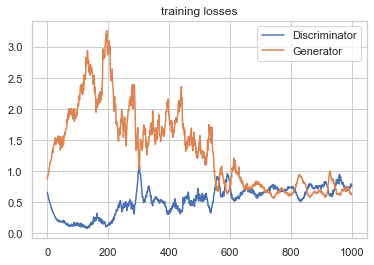

In [18]:
fig, ax = plt.subplots()
plt.plot(d_history, label= 'Discriminator')
plt.plot(g_history, label= 'Generator')
plt.title('training losses')
plt.legend()
plt.show()

## Prediction

In [19]:
batch_size = 128

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results = []

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [20]:
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for non_fraud label:', np.round(results_df.loc[results_df['y_test'] == 0, 'results'].mean(),2))
print ('Mean score for fraud label:', np.round(results_df.loc[results_df['y_test'] == 1, 'results'].mean(),2))

Mean score for non_fraud label: 0.48
Mean score for fraud label: 0.41


### Performance

* threshold : 백분위 5%

In [21]:
per = np.percentile(results,5)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [22]:
print ('Accuracy Score :',np.round(accuracy_score(y_test, y_pred),2) )
print ('Precision :',np.round(precision_score(y_test, y_pred),2))
print ('Recall :',np.round(recall_score(y_test, y_pred),2))
print ('F1 :',np.round(f1_score(y_test, y_pred),2))

Accuracy Score : 0.95
Precision : 0.01
Recall : 0.2
F1 : 0.01


Confusion Matrix :


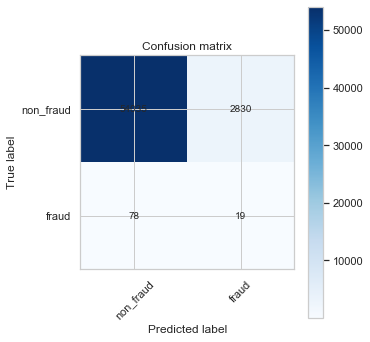

In [23]:
cm = confusion_matrix(y_test, y_pred)
target_names = ['non_fraud', 'fraud']

print ('Confusion Matrix :')

def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm,target_names)

## 장단점
* 장점:
    * 높은 수준의 이미지를 빠르게 생성
* 단점:
    * 이미지 생성용 -> 사람이 판단하는 경우가 많음 (prediction ??)
    * 데이터의 분포를 모르기 때문에 어떤 데이터가 생성될지 알 수 없음

## 참고문헌 / 코드

* https://www.slideshare.net/NaverEngineering/ss-96581209
* https://tv.naver.com/v/1947034
* https://jaaamj.tistory.com/85
<br>
* https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
* https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
<br>
* https://colab.research.google.com/drive/1erOPC6w9szqVDX9oU6gJfE88N1y1Tfwf#scrollTo=HgEqjvXcawyt
* https://www.kaggle.com/sekfook97/gan-for-anomaly-detection/notebook
* https://jovian.ai/jthevos/anomaly-detection-in-network-data-using-gans-98fc4